<a href="https://www.kaggle.com/code/shiladityabasu/disaster-tweet-analysis-classification?scriptVersionId=102600979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
import folium
import warnings
import re
import emoji
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD


plt.style.use('ggplot')

TRAIN_PATH = '../input/nlp-getting-started/train.csv'
TEST_PATH = '../input/nlp-getting-started/test.csv'

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(TRAIN_PATH)
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<AxesSubplot:xlabel='target', ylabel='count'>

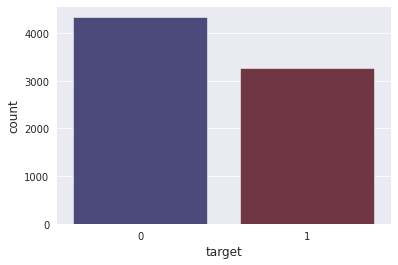

In [6]:
sns.set_style('darkgrid')
sns.countplot(x='target', data=df, palette='icefire')

In [7]:
df_locations_cat = df.groupby(['location', 'target'])[['id']].count().sort_values(by='id', ascending=False)
df_locations_cat

,,id
location,target,
USA,1,67
New York,0,55
USA,0,37
London,0,29
United States,1,27
...,...,...
"Huntsville, Alabama",1,1
Hustletown,1,1
Hyderabad Telangana INDIA,1,1


In [8]:
df_locations_total = df_locations_cat.groupby('location').sum().sort_values(by='id', ascending=False)
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
Hueco Mundo,1
"Hughes, AR",1
"Huntington, WV",1


In [9]:
from functools import lru_cache

@lru_cache(maxsize=100)
def find_long_lat(name: str) -> Tuple[int, int]:
    geolocator = Nominatim(user_agent='user_agent')
    location = geolocator.geocode(name)
    if location:
        return location.longitude, location.latitude
    return 0, 0

In [10]:
print(find_long_lat('Kolkata'))
%time

(88.35769124388872, 22.5414185)
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [11]:
df_locations_total = df_locations_total.iloc[:100]
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
North Carolina,5
Philippines,5
"Cleveland, OH",5


In [12]:
df_locations_total['long'] = df_locations_total \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[0])
df_locations_total['lat'] = df_locations_total  \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[1])

df_locations_total

,id,long,lat
location,,,
USA,104,-100.445882,39.783730
New York,71,-74.006015,40.712728
United States,50,-100.445882,39.783730
London,45,-0.127647,51.507322
Canada,29,-107.991707,61.066692
...,...,...,...
North Carolina,5,-79.039292,35.672964
Philippines,5,122.731210,12.750349
"Cleveland, OH",5,-81.693681,41.499656


In [13]:
map_ = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
# add marker one by one on the map
for i in range(0,len(df_locations_total)):
    folium.Circle(
      location=[df_locations_total.iloc[i]['lat'], df_locations_total.iloc[i]['long']],
      popup=f"{df_locations_total.index[i]}:{df_locations_total.iloc[i]['id']}",
      radius=float(df_locations_total.iloc[i]['id'])*20000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map_)


map_

In [14]:
df_loc_cat_new = df_locations_cat.reset_index()
df_loc_cat_new['target_str'] = df_loc_cat_new['target'].apply(lambda x: 'Disaster' if x == 1 else 'Not disaster')
fig = px.bar(df_loc_cat_new[:50], x='location', y='id', color='target_str')
fig.update_layout(
    title='class count per location (Top 50)',
    xaxis_title='Location', 
    yaxis_title = 'Counts', 
)

### Tweet length

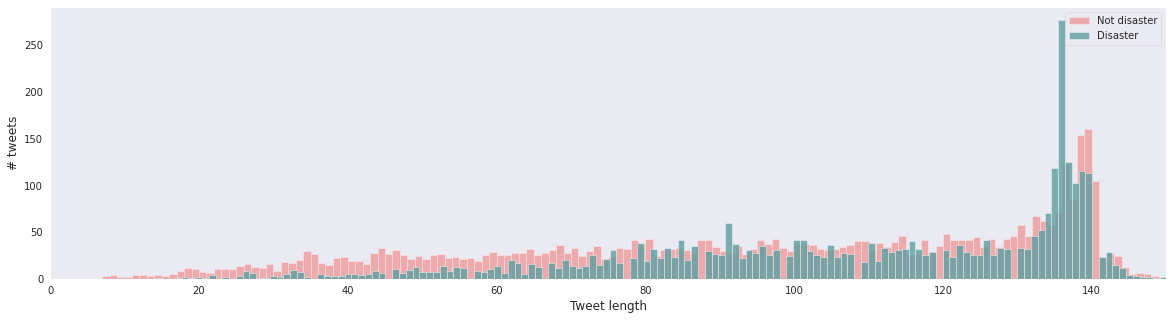

In [15]:
df['tweet_length'] = df['text'].apply(lambda x: len(x))
plt.figure(figsize=(20, 5))
bins = 150
plt.hist(df[df['target'] == 0]['tweet_length'], alpha=0.6, bins=bins, label='Not disaster', color='lightcoral')
plt.hist(df[df['target'] == 1]['tweet_length'], alpha=0.8, bins=bins, label='Disaster', color='cadetblue')
plt.xlabel('Tweet length')
plt.ylabel('# tweets')
plt.legend(loc='upper right')
plt.xlim(0,150)

plt.grid()
plt.show()

In [16]:
df_test = pd.read_csv(TEST_PATH)

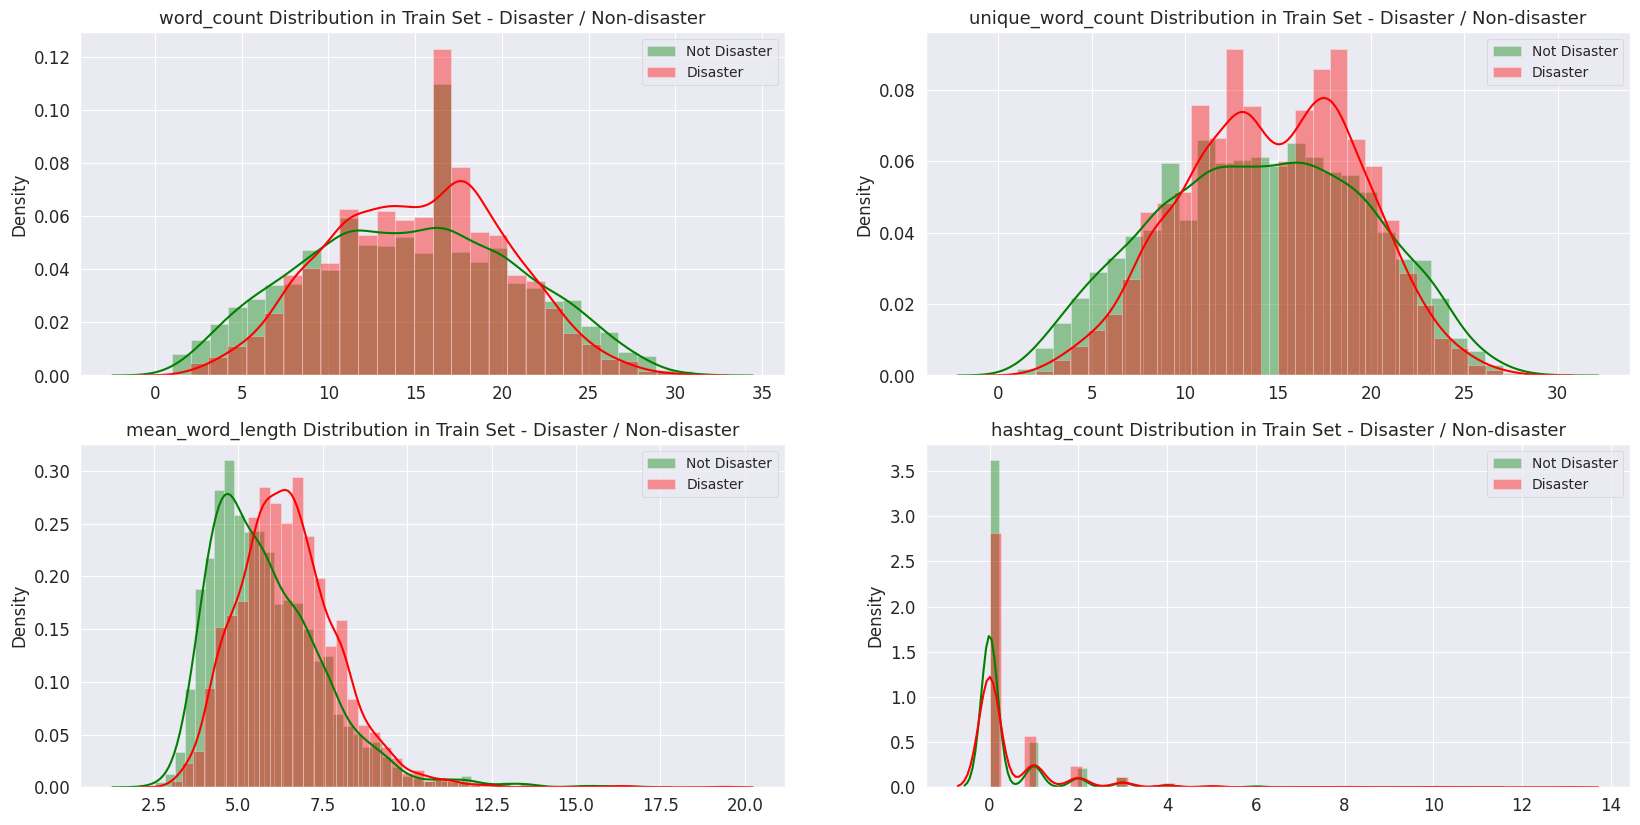

In [17]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(x.split())))

df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in x.split()]))

df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in x if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in x if c == '#']))

FEATURES = ['word_count', 'unique_word_count', 'mean_word_length', 'hashtag_count']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), dpi=100)
for i, feature in enumerate(FEATURES):
    sns.distplot(df[df['target'] == 0][feature], label='Not Disaster', ax=axes[i // 2][i % 2], color='green')
    sns.distplot(df[df['target'] == 1][feature], label='Disaster', ax=axes[i // 2][i % 2], color='red')
    axes[i // 2][i % 2].set_xlabel('')
    axes[i // 2][i % 2].tick_params(axis='x', labelsize=12)
    axes[i // 2][i % 2].tick_params(axis='y', labelsize=12)
    axes[i // 2][i % 2].legend()
    axes[i // 2][i % 2].set_title(f'{feature} Distribution in Train Set - Disaster / Non-disaster', fontsize=13)


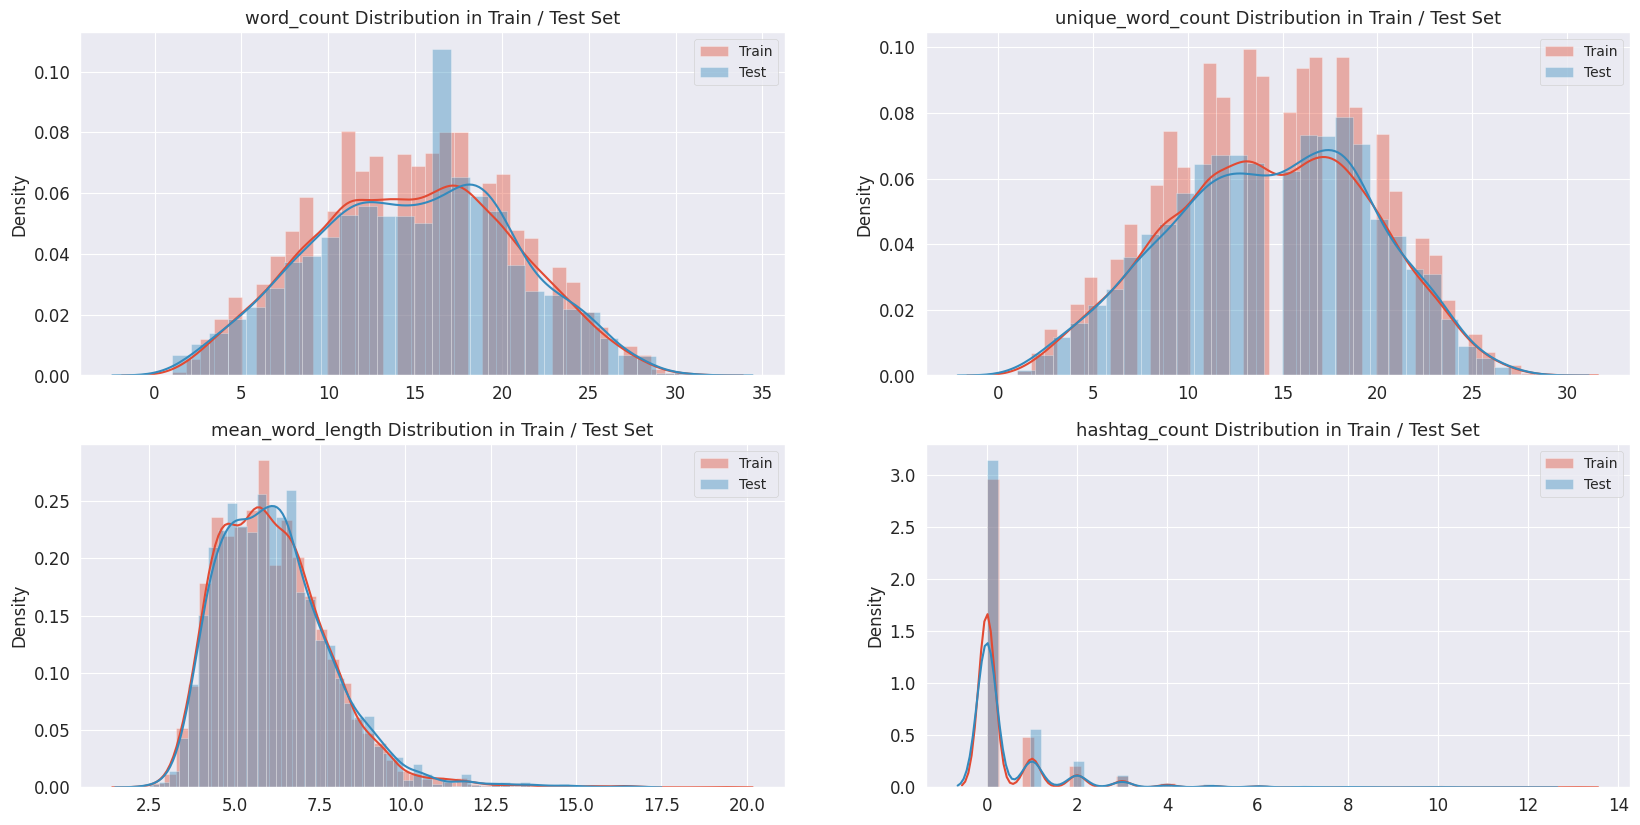

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), dpi=100)
for i, feature in enumerate(FEATURES):
    sns.distplot(df[feature], label='Train', ax=axes[i // 2][i % 2])
    sns.distplot(df_test[feature], label='Test', ax=axes[i // 2][i % 2])

    axes[i // 2][i % 2].set_xlabel('')
    axes[i // 2][i % 2].tick_params(axis='x', labelsize=12)
    axes[i // 2][i % 2].tick_params(axis='y', labelsize=12)
    axes[i // 2][i % 2].legend()
    axes[i // 2][i % 2].set_title(f'{feature} Distribution in Train / Test Set', fontsize=13)


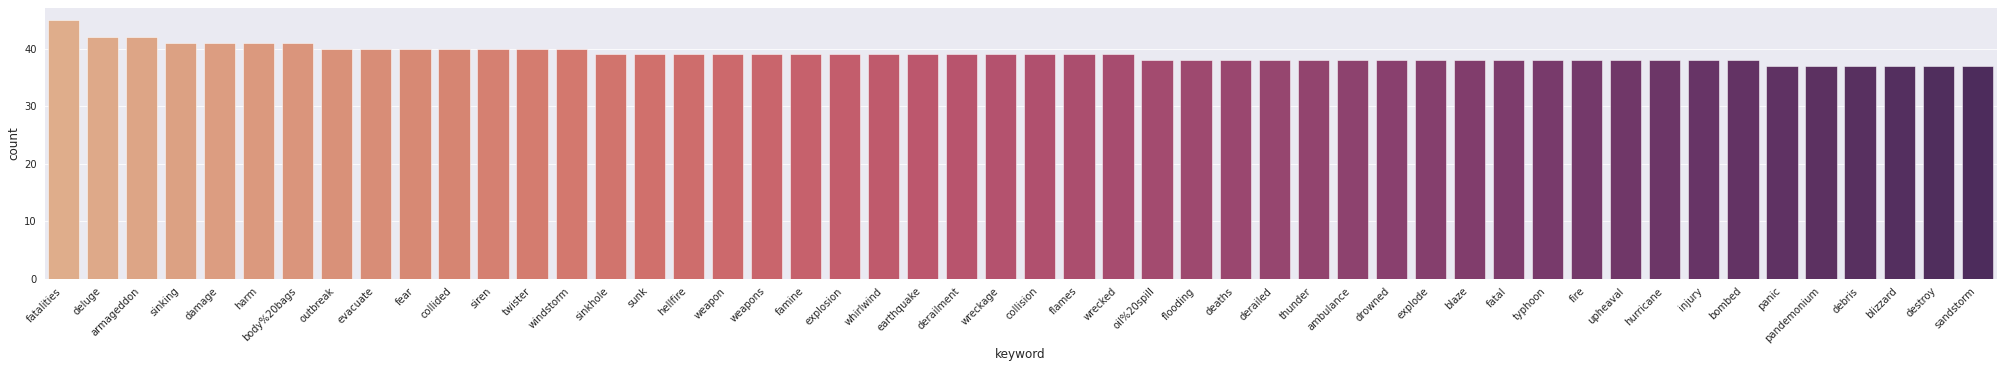

In [19]:
plt.figure(figsize=(35, 5))
kw_counts = sns.countplot(x='keyword', data=df, order=df['keyword'].value_counts()[:50].index, palette='flare')
kw_counts.set_xticklabels(kw_counts.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Data Cleaning

In [20]:
df['keyword'].notnull().sum()

7552

In [21]:
df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

## Hashtag processing and wordcloud

In [22]:
r = re.compile(r'#(\w+)')
# r.findall('lorem #ipsum #dolor #sit #amet #089 #007 hello amazing#help')

df['hashtags'] = df['text'].apply(lambda x: ' '.join(r.findall(x)))
df['hashtags'].iloc[:10]

0                    earthquake
1                              
2                              
3                     wildfires
4              Alaska wildfires
5    RockyFire CAfire wildfires
6                flood disaster
7                              
8                              
9                              
Name: hashtags, dtype: object

Text(0.5, 1.0, 'Number of Hashtags')

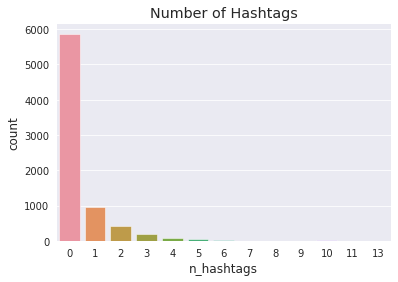

In [23]:
df['n_hashtags'] = df['hashtags'].apply(lambda x: len(x.split()))
fig = sns.countplot(x='n_hashtags', data=df)
fig.set_title("Number of Hashtags")

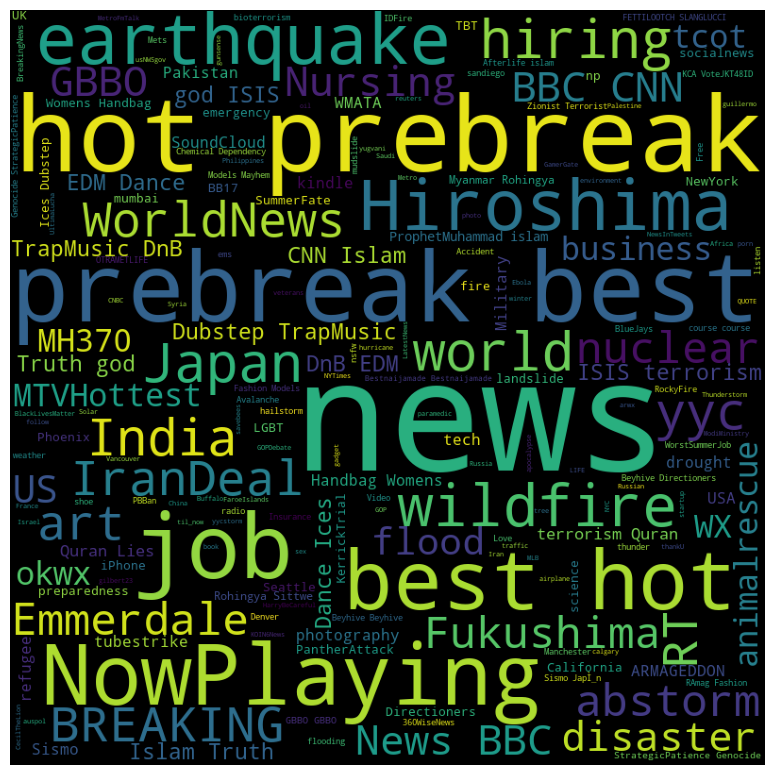

In [24]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 10), dpi=100)
hashtag_corpus = []
for arr in df['hashtags']:
    hashtag_corpus.append(arr)
corpus = ' '.join(hashtag_corpus)
wc_hashtags = WordCloud(background_color='black', width=800, height=800).generate(corpus)
plt.imshow(wc_hashtags)
plt.axis('off')
plt.show()


In [25]:
n_dups = len(df[df.duplicated(subset=['text'])])
len_before = len(df)

df.drop_duplicates(subset=['text'], inplace=True)
print(f'{len_before} - {len(df)} = {n_dups} duplicate tweets have been removed')

7613 - 7503 = 110 duplicate tweets have been removed


## Data Cleaning

We have to do some basic preprocessing to remove unnecessary items such as emojis, and urls from the tweets. Additionally, hashtags would need to have the pound sign removed from them as they do not add any additional information (other than identifying hashtags, which we extracted already)

For this purpose we are doing all our cleaning on a copy of our dataframe. After performing sufficient analysis and visualization on the cleaned data and additionally extracted data we will build a pipeline for processing the primary dataframe.


In [26]:
df_copy = df.copy()

### Removing Emojis

In [27]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text: str):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [28]:
df_copy['text_cleaned'] = df_copy['text'].apply(remove_emoji)
df_copy['text_cleaned'].describe()

count                                                  7503
unique                                                 7503
top       Our Deeds are the Reason of this #earthquake M...
freq                                                      1
Name: text_cleaned, dtype: object

### Removing URLS

In [29]:
test_str = 'hello world https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string'

def remove_urls(text: str):
    r = re.compile('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+')
    return r.sub(r'', text)

remove_urls(test_str)

'hello world '

In [30]:
df_copy['text_cleaned'] = df_copy['text_cleaned'].apply(remove_urls)
df_copy['text_cleaned'].describe()

count                                                  7503
unique                                                 6985
top       Watch This Airport Get Swallowed Up By A Sands...
freq                                                     24
Name: text_cleaned, dtype: object

In [31]:
df_copy.drop_duplicates(subset=['text_cleaned'], keep='first', inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6985 entries, 0 to 7606
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6985 non-null   int64  
 1   keyword            6932 non-null   object 
 2   location           4682 non-null   object 
 3   text               6985 non-null   object 
 4   target             6985 non-null   int64  
 5   tweet_length       6985 non-null   int64  
 6   word_count         6985 non-null   int64  
 7   unique_word_count  6985 non-null   int64  
 8   mean_word_length   6985 non-null   float64
 9   hashtag_count      6985 non-null   int64  
 10  hashtags           6985 non-null   object 
 11  n_hashtags         6985 non-null   int64  
 12  text_cleaned       6985 non-null   object 
dtypes: float64(1), int64(7), object(5)
memory usage: 764.0+ KB


### Remove Mentions and Hashtags
We already captured hashtags in a seperate column. Mentions begin with `@`, we can similarly collect the mentions in each tweet and remove them subsequently.

In [32]:
r = re.compile(r'@(\w+)')
df_copy['mentions'] = df_copy['text_cleaned'].apply(lambda x: ' '.join(r.findall(x)))
df_copy['mentions'].value_counts()

                       5026
YouTube                  59
POTUS                     6
emmerdale                 5
FoxNews                   4
                       ... 
NYPDnews                  1
Joelsherman1              1
wmata unsuckdcmetro       1
firstpostin               1
engineshed                1
Name: mentions, Length: 1793, dtype: int64

### Remove Punctuations

In [33]:
import string
def remove_punct(text: str):
    return text.translate(str.maketrans('', '', string.punctuation))

remove_punct('hello everyone #hashtag')

'hello everyone hashtag'

In [34]:
df_copy['text_cleaned'] = df_copy['text_cleaned'].apply(remove_punct)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6985 entries, 0 to 7606
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6985 non-null   int64  
 1   keyword            6932 non-null   object 
 2   location           4682 non-null   object 
 3   text               6985 non-null   object 
 4   target             6985 non-null   int64  
 5   tweet_length       6985 non-null   int64  
 6   word_count         6985 non-null   int64  
 7   unique_word_count  6985 non-null   int64  
 8   mean_word_length   6985 non-null   float64
 9   hashtag_count      6985 non-null   int64  
 10  hashtags           6985 non-null   object 
 11  n_hashtags         6985 non-null   int64  
 12  text_cleaned       6985 non-null   object 
 13  mentions           6985 non-null   object 
dtypes: float64(1), int64(7), object(6)
memory usage: 818.6+ KB


In [35]:
import pickle

def load_glove():
    pkl_path = '../input/glove-twitter-pickles-27b-25d-50d-100d-200d/glove.twitter.27B.100d.pkl'
    with open(pkl_path, 'rb') as f:
        glove = pickle.load(f)
    return glove

glove = load_glove()

In [36]:
# turn to lowercase
df_copy['text_cleaned'] = df_copy['text_cleaned'].apply(lambda x: x.casefold())
df_copy['text_cleaned'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text_cleaned, dtype: object

In [37]:
def create_corpus(df: pd.DataFrame, col: str):
    corpus_ = {}
    for text in df[col]:
        for word in word_tokenize(text):
            if corpus_.get(word, None) is None:
                corpus_[word] = 1
            else:
                corpus_[word] += 1
    
    return corpus_

In [38]:
corpus = create_corpus(df=df_copy, col='text_cleaned')
'usa' in corpus

True

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity(word1: str, word2: str):
    vec1, vec2 = glove.get(word1, None), glove.get(word2, None)
    if vec1 is None or vec2 is None:
        return np.zeros(1)
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    return cosine_similarity(vec1, vec2)

In [40]:
similarity('cow', 'moose')

array([[0.6273453]], dtype=float32)

In [41]:
tweet = df_copy.iloc[42].text_cleaned
keyword = df_copy.iloc[42].keyword

def produce_sim_array(sentence: str, keyword: str):
    vecs = []
    vecs = [similarity(w, keyword) for w in word_tokenize(sentence)]
    return np.vstack(vecs)

produce_sim_array(tweet, keyword)

array([[ 0.09170683],
       [ 0.08496878],
       [-0.01057406],
       [-0.04254753],
       [ 0.23947239],
       [ 0.04461424],
       [-0.01100196],
       [ 0.17207745],
       [ 0.08935672],
       [ 0.04461424],
       [ 0.        ],
       [ 0.016429  ],
       [ 0.09382004],
       [ 1.        ],
       [-0.13481475],
       [ 0.04241401],
       [-0.09043977],
       [-0.19656885],
       [ 0.02680533],
       [ 0.15102491],
       [-0.14454412],
       [ 0.09829105],
       [ 0.07062045]])